In [1]:
# First import tensorflow
import tensorflow as tf
tf.__version__

'2.12.0'

# Binary Classification

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied





## 1. Import and become one with the data


In [2]:
!wget https://raw.githubusercontent.com/nikbhaladhare2104/TensorFlow-functions/TensorFlow/helper_functions.py

--2023-08-09 08:11:29--  https://raw.githubusercontent.com/nikbhaladhare2104/TensorFlow-functions/TensorFlow/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15781 (15K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  15.41K  --.-KB/s    in 0s      

2023-08-09 08:11:29 (145 MB/s) - ‘helper_functions.py’ saved [15781/15781]



In [3]:
# Get the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

--2023-08-09 08:11:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.128, 142.251.175.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  22.4MB/s    in 5.9s    

2023-08-09 08:11:36 (17.7 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [4]:
from helper_functions import unzip_data, view_random_image

In [5]:
unzip_data("pizza_steak.zip")

In [6]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


Image shape: (341, 512, 3)
Image shape: (512, 512, 3)


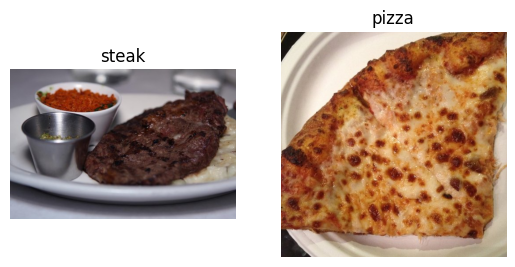

In [7]:
# Visualise the data by plotting it
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak" )
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")


##2. Preprocess the data (prepare it for a model)

In [8]:
tf.__version__

'2.12.0'

In [9]:
# data generators and rescale
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

In [10]:
# Turn data into batches
train_data = train_data_gen.flow_from_directory(directory="pizza_steak/train/",
                                                target_size=(224, 224),
                                                class_mode="binary", # for multi : categorical
                                                batch_size=32
                                                )
test_data = test_data_gen.flow_from_directory(directory="pizza_steak/test/",
                                              target_size=(224, 224),
                                              class_mode="binary",
                                              batch_size=32)



Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


See the first image from the data

In [11]:
images, labels = train_data[0]
len(images), len(labels)

(32, 32)

we have images into batches of 32

In [12]:
images[0], images[0].shape

(array([[[0.18823531, 0.20392159, 0.24705884],
         [0.20784315, 0.21960786, 0.25490198],
         [0.28235295, 0.28235295, 0.32156864],
         ...,
         [0.41960788, 0.49411768, 0.54901963],
         [0.54509807, 0.61960787, 0.6862745 ],
         [0.34901962, 0.43137258, 0.49803925]],
 
        [[0.54509807, 0.56078434, 0.6039216 ],
         [0.5568628 , 0.5647059 , 0.6117647 ],
         [0.5686275 , 0.5686275 , 0.6156863 ],
         ...,
         [0.18823531, 0.25882354, 0.30588236],
         [0.19607845, 0.27058825, 0.3254902 ],
         [0.25490198, 0.32941177, 0.38823533]],
 
        [[0.59607846, 0.6117647 , 0.65882355],
         [0.59607846, 0.6039216 , 0.654902  ],
         [0.59607846, 0.6039216 , 0.6509804 ],
         ...,
         [0.2509804 , 0.31764707, 0.35686275],
         [0.27058825, 0.34117648, 0.3803922 ],
         [0.18039216, 0.2509804 , 0.29803923]],
 
        ...,
 
        [[0.8352942 , 0.83921576, 0.8588236 ],
         [0.83921576, 0.8431373 , 0.86274

In [13]:
labels

array([1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.],
      dtype=float32)

##3. Create a model



Starting with baseline model

A 3 layer convolutional neural network.

In [14]:
# This makes life easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential


In [15]:
# set random seed
tf.random.set_seed(42)

# Create the model
model_1 = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding="valid",
           activation="relu",
           input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10 ,3 , activation="relu"),
    Flatten(),
    Dense(1, activation="sigmoid")
])


Now our model is ready, let's compile it.



In [16]:
#Compile the model
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])


## 4. Fit the model

In [17]:
len(train_data), len(test_data)

(47, 16)

In [18]:
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))


Epoch 1/5
47/47 [==============================] - 19s 156ms/step - loss: 1.0869 - accuracy: 0.5987 - val_loss: 0.5019 - val_accuracy: 0.7640
Epoch 2/5
47/47 [==============================] - 6s 137ms/step - loss: 0.4668 - accuracy: 0.7893 - val_loss: 0.3893 - val_accuracy: 0.8460
Epoch 3/5
47/47 [==============================] - 5s 116ms/step - loss: 0.3294 - accuracy: 0.8733 - val_loss: 0.3717 - val_accuracy: 0.8640
Epoch 4/5
47/47 [==============================] - 6s 131ms/step - loss: 0.2072 - accuracy: 0.9313 - val_loss: 0.3840 - val_accuracy: 0.8440
Epoch 5/5
47/47 [==============================] - 8s 164ms/step - loss: 0.1132 - accuracy: 0.9713 - val_loss: 0.4001 - val_accuracy: 0.8400


## 5. Evaluate the model

<Axes: >

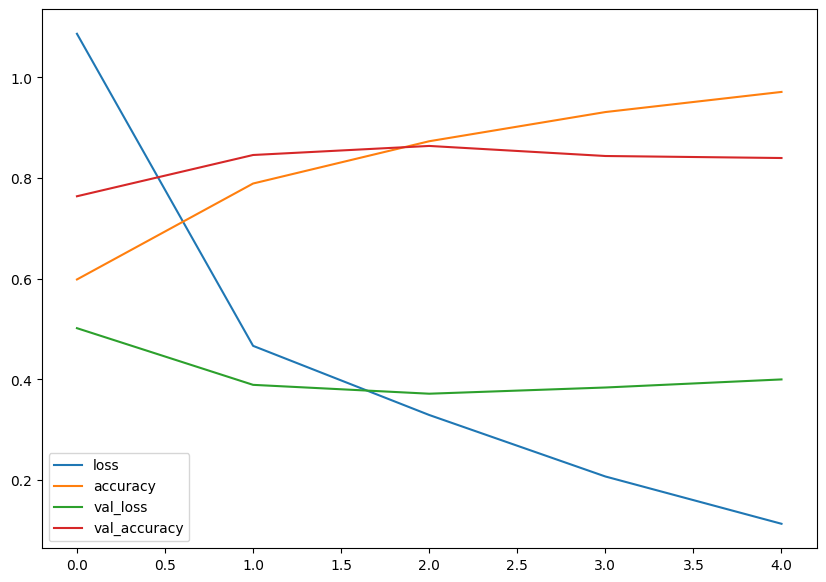

In [19]:
import pandas as pd
pd.DataFrame(history_1.history).plot(figsize=(10,7))

Our model is clearly overfitting

Lets try differnet curves for loss and accuracy

In [20]:
from helper_functions import plot_loss_curves

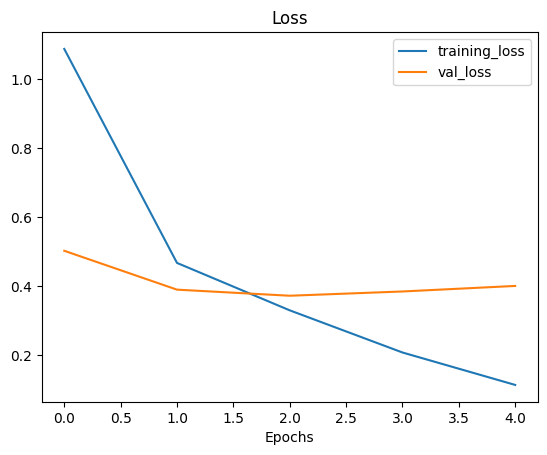

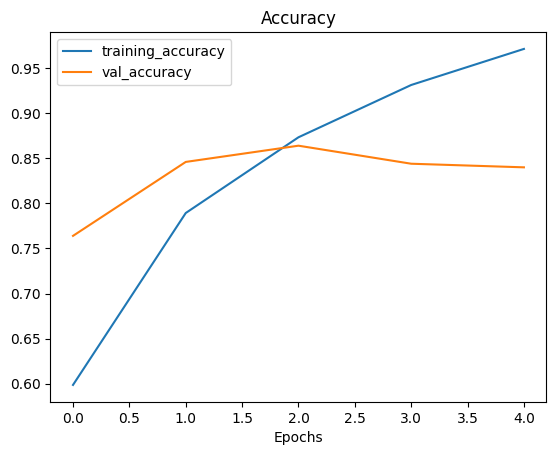

In [21]:
plot_loss_curves(history_1)

If there is a clear gap between train and validation curves at the end, then models is probably **Overfitting**

In [22]:
# Architecture
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_2 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten (Flatten)           (None, 475240)            0         
                                                                 
 dense (Dense)               (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


##6. Adjust the model parameters

Fitting a machine learning model comes in 3 steps:
 0. Create a basline.

1. Beat the baseline by overfitting a larger model.
2. Reduce overfitting.

We will do the 2 point , since we will be working on the same data

For this , we will use MaxPool2D layer after each Conv2D layer

In [23]:
# Create the model
model_2 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3 , activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")

])


In [24]:
# compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [25]:
#Fit yhe model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))


Epoch 1/5
47/47 [==============================] - 11s 156ms/step - loss: 0.6141 - accuracy: 0.6407 - val_loss: 0.4983 - val_accuracy: 0.7440
Epoch 2/5
47/47 [==============================] - 5s 112ms/step - loss: 0.4515 - accuracy: 0.7947 - val_loss: 0.3606 - val_accuracy: 0.8460
Epoch 3/5
47/47 [==============================] - 7s 142ms/step - loss: 0.3966 - accuracy: 0.8320 - val_loss: 0.3549 - val_accuracy: 0.8560
Epoch 4/5
47/47 [==============================] - 5s 112ms/step - loss: 0.3684 - accuracy: 0.8393 - val_loss: 0.3761 - val_accuracy: 0.8160
Epoch 5/5
47/47 [==============================] - 6s 131ms/step - loss: 0.3821 - accuracy: 0.8353 - val_loss: 0.3121 - val_accuracy: 0.8740


In [26]:
# architecture
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 10)     0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 10)      

params for model_2 is less than model_1...
because of MaxPool2D layer. (pool_size)

It halved the number of params and only pass most important features in each layer

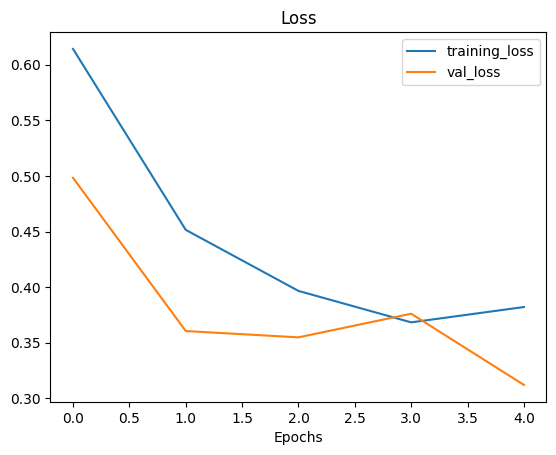

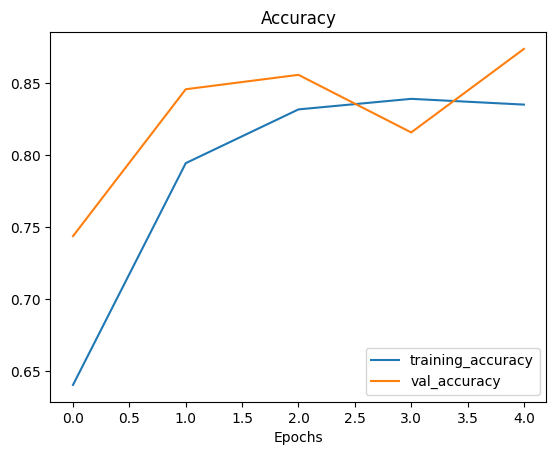

In [27]:
# plot loss curves
plot_loss_curves(history_2)

Nice...!

Curves are getting closer to each other,...

But at the end Validation accuracy seems to be  decreasing at the end , And in turn potentially  leading to **Overfitting**

### Data Augmentation

In [28]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

In [29]:
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

In [30]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


In [31]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same


In [32]:
import random

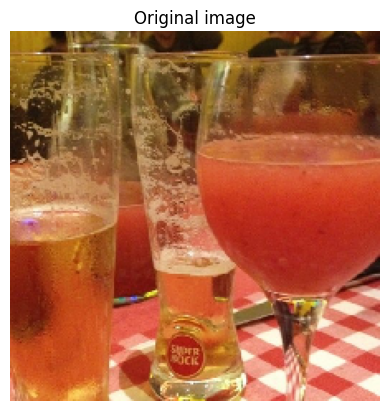

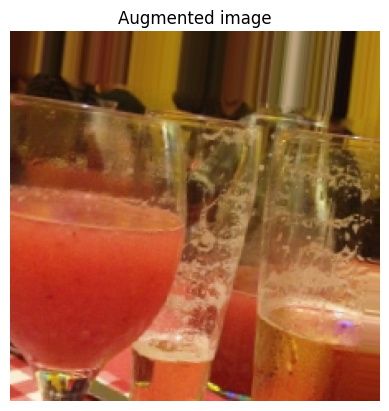

In [33]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [34]:
# Create the model
model_3 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_3 = model_3.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 23s 454ms/step - loss: 0.6992 - accuracy: 0.4200 - val_loss: 0.6908 - val_accuracy: 0.5840
Epoch 2/5
47/47 [==============================] - 21s 453ms/step - loss: 0.6842 - accuracy: 0.5793 - val_loss: 0.6438 - val_accuracy: 0.7760
Epoch 3/5
47/47 [==============================] - 20s 429ms/step - loss: 0.7491 - accuracy: 0.5633 - val_loss: 0.6457 - val_accuracy: 0.6020
Epoch 4/5
47/47 [==============================] - 21s 454ms/step - loss: 0.7232 - accuracy: 0.4673 - val_loss: 0.6469 - val_accuracy: 0.5600
Epoch 5/5
47/47 [==============================] - 21s 444ms/step - loss: 0.6734 - accuracy: 0.6160 - val_loss: 0.6180 - val_accuracy: 0.7720


Why didn't our model get very good results on the training set to begin with?

It's because when we created train_data_augmented we turned off data shuffling using shuffle=False which means our model only sees a batch of a single kind of images at a time.

For example, the pizza class gets loaded in first because it's the first class. Thus it's performance is measured on only a single class rather than both classes. The validation data performance improves steadily because it contains shuffled data.

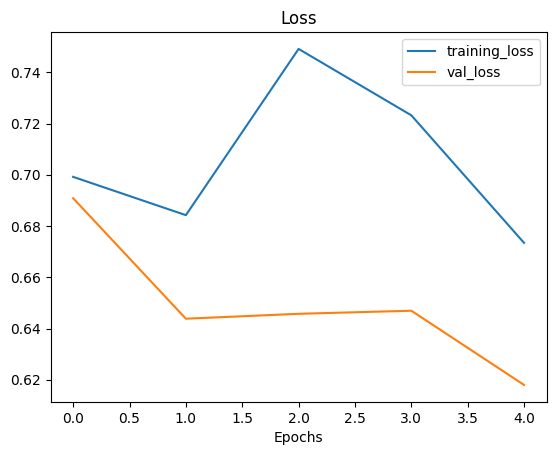

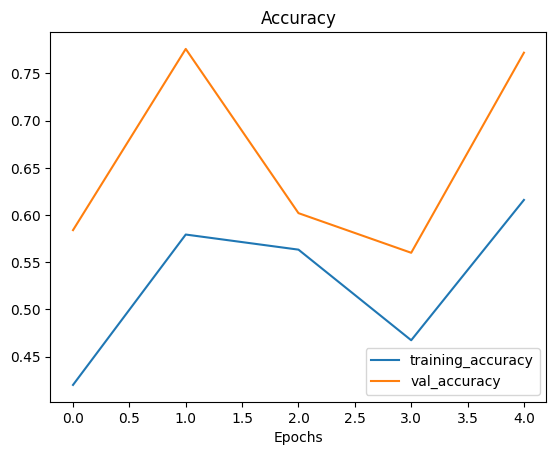

In [35]:
# Check model's performance history training on augmented data
plot_loss_curves(history_3)

It seems our validation loss curve is heading in the right direction but it's a bit jumpy (the most ideal loss curve isn't too spiky but a smooth descent).

Let's see what happens when we shuffle the augmented training data.



In [36]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data

Found 1500 images belonging to 2 classes.


In [37]:
# Create the model
model_4 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_4 = model_4.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 24s 451ms/step - loss: 0.6723 - accuracy: 0.5887 - val_loss: 0.5903 - val_accuracy: 0.6960
Epoch 2/5
47/47 [==============================] - 21s 453ms/step - loss: 0.5585 - accuracy: 0.7173 - val_loss: 0.4039 - val_accuracy: 0.8200
Epoch 3/5
47/47 [==============================] - 20s 424ms/step - loss: 0.5016 - accuracy: 0.7553 - val_loss: 0.3610 - val_accuracy: 0.8640
Epoch 4/5
47/47 [==============================] - 21s 452ms/step - loss: 0.4769 - accuracy: 0.7807 - val_loss: 0.3266 - val_accuracy: 0.8620
Epoch 5/5
47/47 [==============================] - 20s 428ms/step - loss: 0.4656 - accuracy: 0.7740 - val_loss: 0.3528 - val_accuracy: 0.8580


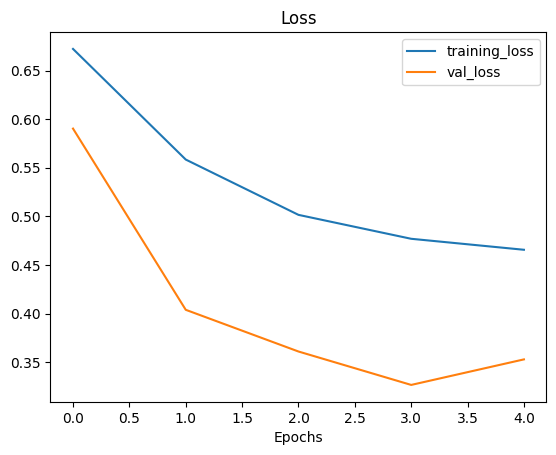

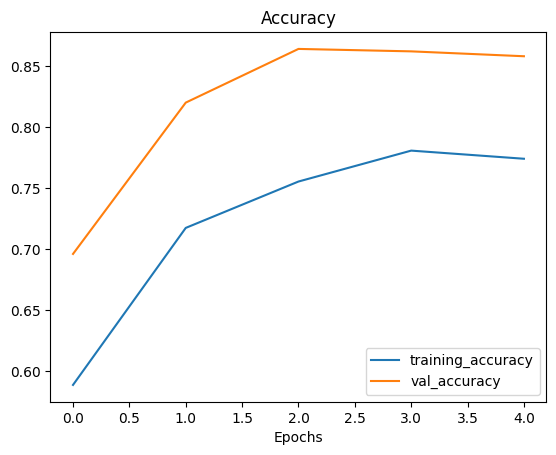

In [38]:
# Check model's performance history training on augmented data
plot_loss_curves(history_4)

Much better...!

Notice with model_4 how the performance on the training dataset improves almost immediately compared to model_3. This is because we shuffled the training data as we passed it to the model using the parameter shuffle=True in the flow_from_directory method.

This means the model was able to see examples of both pizza and steak images in each batch and in turn be evaluated on what it learned from both images rather than just one kind.



##7. Repeat until satisified


Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:

1. Increase the number of model layers (e.g. add more convolutional layers).
2. Increase the number of filters in each convolutional layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).
3. Train for longer (more epochs).
4. Finding an ideal learning rate.
5. Get more data (give the model more opportunities to learn).
6. Use **transfer learning** to leverage what another image model has learned and adjust it for our own use case.


First 4 points usually reffered to as **Hyperparameter Tuning**.



In [39]:
# Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_5 = model_5.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 24s 441ms/step - loss: 0.6479 - accuracy: 0.6173 - val_loss: 0.5218 - val_accuracy: 0.7180
Epoch 2/5
47/47 [==============================] - 22s 457ms/step - loss: 0.5079 - accuracy: 0.7493 - val_loss: 0.3584 - val_accuracy: 0.8420
Epoch 3/5
47/47 [==============================] - 22s 459ms/step - loss: 0.4776 - accuracy: 0.7860 - val_loss: 0.3548 - val_accuracy: 0.8480
Epoch 4/5
47/47 [==============================] - 22s 467ms/step - loss: 0.4765 - accuracy: 0.7760 - val_loss: 0.3983 - val_accuracy: 0.8160
Epoch 5/5
47/47 [==============================] - 22s 468ms/step - loss: 0.4924 - accuracy: 0.7620 - val_loss: 0.3434 - val_accuracy: 0.8480


In [40]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 10)     0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 10)      

In [41]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_13 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_15 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                 

Now let's check out our TinyVGG model's performance.



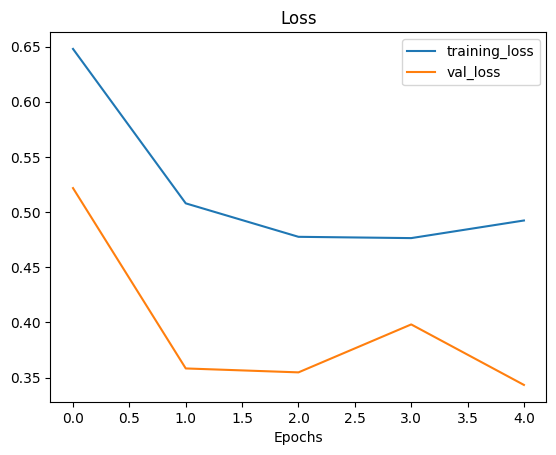

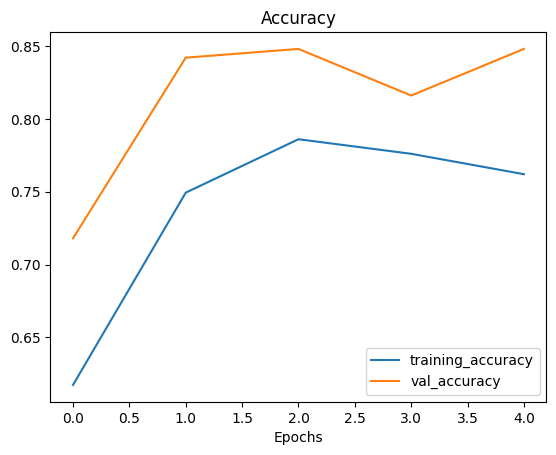

In [42]:
# Check out the TinyVGG model performance
plot_loss_curves(history_5)

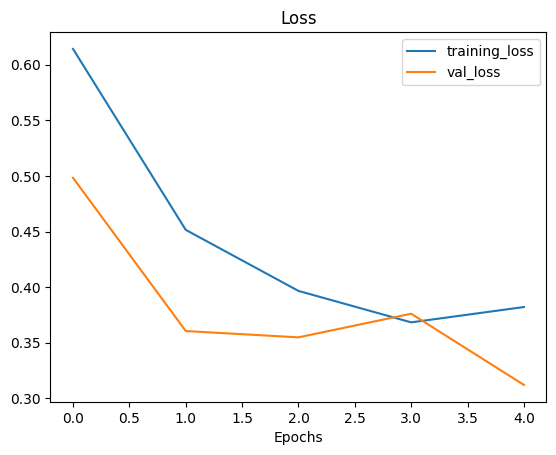

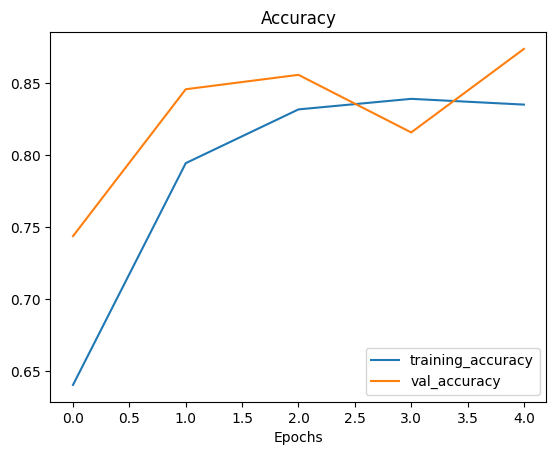

In [43]:
# How does this training curve look compared to the one above?
plot_loss_curves(history_2)

Not much difference between 2 ....

If the model is not overfitting, dont use augmentation, bbut if it is , then its good to use it to reduce overfitting

###Making a prediction with our trained model

In [44]:
# Classes we're working with
print(class_names)

['pizza' 'steak']


In [45]:
import matplotlib.pyplot as plt


In [46]:
# Get the image to predict on
!wget https://raw.githubusercontent.com/nikbhaladhare2104/TensorFlow-Extraa/TensorFlow/images/3-CNN-Classification/03-steak.jpeg

--2023-08-09 08:19:42--  https://raw.githubusercontent.com/nikbhaladhare2104/TensorFlow-Extraa/TensorFlow/images/3-CNN-Classification/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.008s  

2023-08-09 08:19:42 (229 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



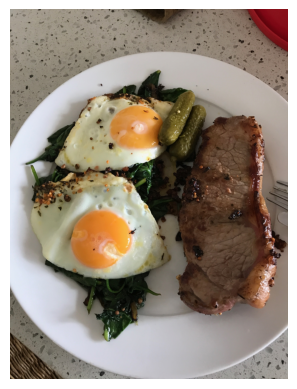

In [47]:
import matplotlib.image as mpimg
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [48]:
steak.shape

(4032, 3024, 3)

Since our model takes in images of shapes (224, 224, 3), we've got to reshape our custom image to use it with our model.

To do so, we can import and decode our image using **tf.io.read_file** (for readining files) and **tf.image** (for resizing our image and turning it into a tensor).

We will use the helper function **load_and_prep_image** to do this...!

In [49]:
from helper_functions import load_and_prep_image

In [50]:
steak = load_and_prep_image("03-steak.jpeg")

In [51]:
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

Lets predict ....

model_5.predict(steak)
.... Will not work because our model was trained on 32 images at a time, (batch_size, 224, 224, 3) , so model will accept 4 dims rather than 3

Lets expand dimension of our image using **tf.expand_dims.**

In [52]:
print(f"Original dimension: {steak.shape}" )
steak = tf.expand_dims(steak, axis=0)
print(f"New dimension: {steak.shape}")
steak

Original dimension: (224, 224, 3)
New dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.6377451 , 0.6220588 , 0.57892156],
         [0.6504902 , 0.63186276, 0.5897059 ],
         [0.63186276, 0.60833335, 0.5612745 ],
         ...,
         [0.52156866, 0.05098039, 0.09019608],
         [0.49509802, 0.04215686, 0.07058824],
         [0.52843136, 0.07745098, 0.10490196]],

        [[0.6617647 , 0.6460784 , 0.6107843 ],
         [0.6387255 , 0.6230392 , 0.57598037],
         [0.65588236, 0.63235295, 0.5852941 ],
         ...,
         [0.5352941 , 0.06862745, 0.09215686],
         [0.529902  , 0.05931373, 0.09460784],
         [0.5142157 , 0.05539216, 0.08676471]],

        [[0.6519608 , 0.6362745 , 0.5892157 ],
         [0.6392157 , 0.6137255 , 0.56764704],
         [0.65637255, 0.6269608 , 0.5828431 ],
         ...,
         [0.53137255, 0.06470589, 0.08039216],
         [0.527451  , 0.06862745, 0.1       ],
         [0.52254903, 0.05196078, 0.0872549 ]],

        ...,

        [[0.49313724, 0.42745098, 

Our custom image has a batch size of 1! Let's make a prediction on it.



In [53]:
pred = model_5.predict(steak)
pred

1/1 [==============================] - 0s 223ms/step


array([[0.7638539]], dtype=float32)

In [54]:
# We can index the predicted class by rounding the prediction probability
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'steak'

Using helper function to predict and plot the custom image ...

In [55]:
from helper_functions import pred_and_plot

1/1 [==============================] - 0s 21ms/step


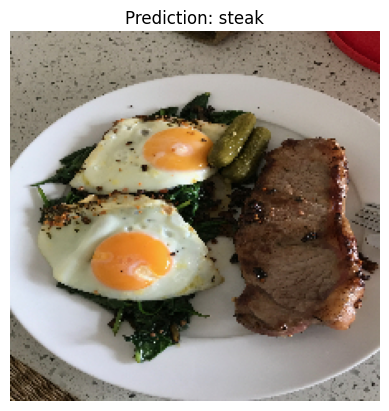

In [56]:
pred_and_plot(model_5, "03-steak.jpeg", class_names)

Nice...!



Our model got the prediction right.

Let's try one more image.



In [57]:
# Download another test image and make a prediction on it
!wget https://raw.githubusercontent.com/nikbhaladhare2104/TensorFlow-Extraa/TensorFlow/images/3-CNN-Classification/03-pizza-dad.jpeg


--2023-08-09 08:20:52--  https://raw.githubusercontent.com/nikbhaladhare2104/TensorFlow-Extraa/TensorFlow/images/3-CNN-Classification/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.01s   

2023-08-09 08:20:52 (207 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]



1/1 [==============================] - 0s 20ms/step


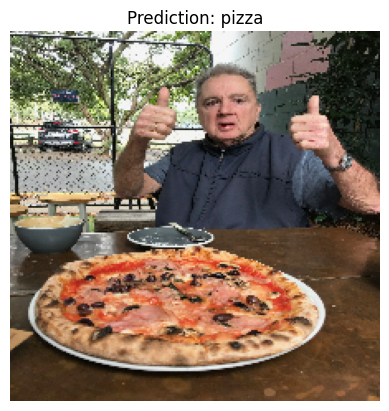

In [58]:
pred_and_plot(model_5, "03-pizza-dad.jpeg", class_names)

Woah...!

Our model predicted both the images correctly...

Thats it...